### Skymap is a database that offers:

1. a single data matrix for each omic layer for each specie that spans >200k sequencing runs from all the public studies, which is done by reprocessing Peta-bytes worth of sequencing data.
2. a metadata file that describe the relationships between the sequencing runs and also the keywords extracted from freetext annotations using NLP.
The data is hosted in here: https://www.synapse.org/skymap (take < 3 minutes to set up the account). Code is hosted in github, the jupyer-notebooks aim to show analysis examples of going from data slicing to hypothesis testing. 



  
### Purpose of this notebook:  using skymap to slice out the sequencing runs associated with a BRAF V600 mutation and correlate it with expression (EQTL). 

Highlights:
* Take only seconds to slicing all the allelic read counts for the samples with data near BRAF V600 position.  
* Identify associations using NLP extracted labels from experimental annotations
* Take < 1 minute to slice out the relevant expression matrix and associate with expression. 
* identify experiemnts where mutation is shown in molecular data but not in the text annotation. 


## Take <20 lines of code to slice out 100k experiments and their SNP near BRAF V600

In [42]:
### parameters
import pandas as pd
import numpy as np
mySpecie='Homo_sapiens'
skymap_snp_dir='/cellar/users/btsui/Data/SRA/snp/{specie}_snp_pos/'.format(specie=mySpecie)

### BRAF V600 coordinate 

In [43]:
#location where BRAF V600 happens, you can change it to whatever position you want 
queryChr,queryPosition='7',140753336 
#http://cancer.sanger.ac.uk/cosmic/mutation/overview?id=476

In [44]:
window=15
readThreshold=5

static code for slicing out the data

In [45]:
%%time
chunkSize=100000 #fixed params
myChunk=(queryPosition/chunkSize)*chunkSize
hdf_s=pd.HDFStore(skymap_snp_dir+'Pos_block_'+str(myChunk),mode='r')
tmpChunkDf=hdf_s['/chunk']
myPosDf=tmpChunkDf[(tmpChunkDf.Pos>=(queryPosition-window))&(tmpChunkDf.Pos<=(queryPosition+window))].reset_index()
m1=myPosDf['Chr']==queryChr
m2=myPosDf['ReadDepth']>=readThreshold
myChrPosDf=myPosDf[m1&m2]

CPU times: user 468 ms, sys: 128 ms, total: 596 ms
Wall time: 597 ms


In [46]:
print '# of studies sliced out:' ,tmpChunkDf.Run_digits.nunique()

# of studies sliced out: 149064


### the slice out the window at around BRAF V600

In [47]:
myChrPosDf.head()

features Chr base Run_db  Run_digits        Pos  ReadDepth  \
2          7    C    SRR     1177675  140753321          9   
3          7    C    SRR     4444531  140753321          5   
6          7    C    SRR     5882370  140753321         39   
9          7    C    SRR     5111728  140753321          5   
17         7    C    SRR     2125816  140753321          5   

features  AverageBaseQuality      block  
2                         39  140700000  
3                         40  140700000  
6                         39  140700000  
9                         39  140700000  
17                        37  140700000

### combine with reference base

###### find reference base for each chrosome coordinate

In [48]:

inVcfDir='/data/cellardata/users/btsui/dbsnp/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)
my_chrom_vcfDf=vcfDf[(vcfDf['Chr']==queryChr)]
posToRefBase=my_chrom_vcfDf.set_index('Pos')['RefBase']
posToRefBase=posToRefBase.str[0]
posToRefBase=posToRefBase.groupby(posToRefBase.index).first()


### visualize the data overpresenation of BRAFV600

Since human sequencing data are mostly generated from cell lines, we expect the cells measured often come with a highly  specifc oncogeneic transformation, thus we should observe a overpresenation of data with BRAFV600 as compared to its immediate neighboring regions, as shown in the following figure.

In [49]:

### recover reference base
myChrPosDf['RefBase']=posToRefBase.loc[myChrPosDf['Pos']].values

### is base alt?
myChrPosDf['AltBase']=myChrPosDf['RefBase']!=myChrPosDf['base']
#### consider dropping duplciates of Runs (a runs can have multiple bases) 
myPosCountDf=myChrPosDf.groupby(['Pos','AltBase']).size()

/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/cellar/users/btsui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
inDf=myPosCountDf.unstack()
fractionDf=(inDf.T/inDf.sum(axis=1)).T#/inDf.sum(axis=0)

[]

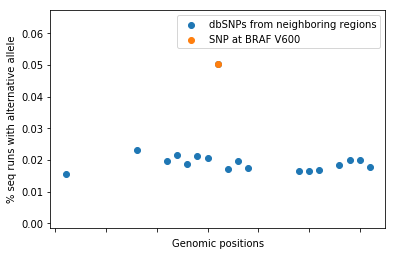

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.scatter(x=fractionDf.index,y=fractionDf[True],label='dbSNPs from neighboring regions')
queryDf=fractionDf[fractionDf.index==queryPosition]
ax.scatter(x=[queryPosition],y=fractionDf.loc[[queryPosition]][True],label='SNP at BRAF V600')
ax.set_ylabel('% seq runs with alternative allele')
ax.set_xlabel('Genomic positions')
ax.legend()
ax.set_xticklabels([])

### BRAF V600 mutation are measured and exracted from many different data layers

as show in the following figure

In [52]:
altBaseDf=myChrPosDf[(myChrPosDf['Pos']==queryPosition)&(myChrPosDf['AltBase'])]

In [53]:
altBaseDf=altBaseDf.set_index(['Run_db','Run_digits'])

In [54]:
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

#### use the techinical meta data table to backtrack which omic layers the experiment is from

In [55]:
technical_meta_data_df.head()

Member_Name  Experiment      Sample Study   Spots      Bases  \
Run                                                                       
SRR2401865     default  SRX1244330  SRS1068422     -  2800.0  1416405.0   
SRR2401866     default  SRX1244331  SRS1068421     -  5082.0  2563605.0   
SRR2401867     default  SRX1244332  SRS1068420     -  6169.0  3175528.0   
SRR2401868     default  SRX1244333  SRS1068419     -  8102.0  4266915.0   
SRR2401869     default  SRX1244334  SRS1068418     -  4971.0  2519200.0   

           Status   ScientificName LibraryStrategy LibraryLayout    ...      \
Run                                                                 ...       
SRR2401865   live  soil_metagenome        AMPLICON        SINGLE    ...       
SRR2401866   live  soil_metagenome        AMPLICON        SINGLE    ...       
SRR2401867   live  soil_metagenome        AMPLICON        SINGLE    ...       
SRR2401868   live  soil_metagenome        AMPLICON        SINGLE    ...       
SRR2401869   live  soil_metagenome        AMPLICON        SINGLE    ...       

           proj_accession_Updated proj_accession_Published  \
Run                                                          
SRR2401865             2015-09-22               2015-09-20   
SRR2401866             2015-09-22               2015-09-20   
SRR2401867             2015-09-22               2015-09-20   
SRR2401868             2015-09-22               2015-09-20   
SRR2401869             2015-09-22               2015-09-20   

           proj_accession_Received proj_accession_Type proj_accession_Center  \
Run                                                                            
SRR2401865              2015-09-15                 RUN            SUB1095135   
SRR2401866              2015-09-15                 RUN            SUB1095135   
SRR2401867              2015-09-15                 RUN            SUB1095135   
SRR2401868              2015-09-15                 RUN            SUB1095135   
SRR2401869              2015-09-15                 RUN            SUB1095135   

           proj_accession_Visibility proj_accession_Loaded  \
Run                                                          
SRR2401865                    public                     1   
SRR2401866                    public                     1   
SRR2401867                    public                     1   
SRR2401868                    public                     1   
SRR2401869                    public                     1   

           proj_accession_ReplacedBy Run_db Run_digits  
Run                                                     
SRR2401865                         -    SRR    2401865  
SRR2401866                         -    SRR    2401866  
SRR2401867                         -    SRR    2401867  
SRR2401868                         -    SRR    2401868  
SRR2401869                         -    SRR    2401869  

[5 rows x 22 columns]

In [56]:
technical_meta_data_df['Run']=technical_meta_data_df.index

In [57]:
technical_meta_data_df=technical_meta_data_df.set_index(['Run_db','Run_digits'])#.index.isin(altBaseDf.index)

In [58]:
hitSrrDf=technical_meta_data_df[technical_meta_data_df.index.isin(altBaseDf.index)]

Text(0,0.5,u'# of sequencing runs')

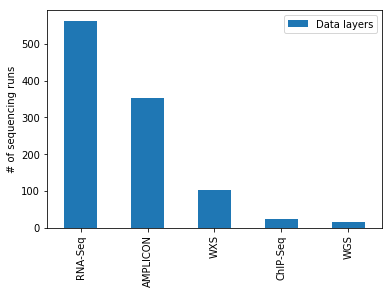

In [59]:
VC=hitSrrDf.LibraryStrategy.value_counts()
ax=VC[VC>0].to_frame('Data layers').plot.bar()
ax.set_ylabel('# of sequencing runs')

# compare with CDK4 and CDK6 expression

* Given that: BRAFV600 mutation is associated proliferation. 
* We should observe stronger proliferation signal: And in this example we use CDK4 and CDK6 expression level as read out for proliferaiton: 
http://cancerdiscovery.aacrjournals.org/content/6/4/353

### memory map the expression data matrix

In [60]:
baseDir='/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/'

def loadDf(fname,mmap_mode='r'):
    with open(fname+'.index.txt') as f:
        myIndex=map(lambda s:s.replace("\n",""), f.readlines())
    with open(fname+'.columns.txt') as f:
        myColumns=map(lambda s:s.replace("\n",""), f.readlines())
    tmpMatrix=np.load(fname+".npy",mmap_mode=mmap_mode)
    tmpDf=pd.DataFrame(tmpMatrix,index=myIndex,columns=myColumns)
    tmpDf.columns.name='Run'
    return tmpDf

In [61]:
expression_metric='TPM'
data_matrix_dir_fmt=baseDir+'/allSRAmatrix.realign.v9.base.{feature}.gene.symbol'.format(feature=expression_metric)
rnaseqDf=loadDf(data_matrix_dir_fmt)

### dimension of expression dataframe 

In [62]:
rnaseqDf.shape

(27233, 126064)

### head of expression dataframe

In [63]:
rnaseqDf.head()

Run    SRR4456480  SRR4456481  SRR4456482  SRR4456483  SRR4456484  SRR4456485  \
A1BG     0.000000     0.00000     0.00000         0.0         0.0     43.4725   
A1CF     0.000000     0.00000     0.00000         0.0         0.0      0.0000   
A2M      0.000000     9.68203     9.63777         0.0         0.0      0.0000   
A2ML1   90.239403     0.00000     0.00000         0.0         0.0      0.0000   
A2MP1    0.000000     0.00000     0.00000         0.0         0.0      0.0000   

Run    SRR4456486  SRR4456487  SRR4456488  SRR4456489     ...      SRR3126580  \
A1BG     42.39500         0.0      0.0000      0.0000     ...       13.633400   
A1CF      0.00000         0.0      0.0000      0.0000     ...        1.008490   
A2M       0.00000         0.0     10.2231     15.0466     ...        0.000000   
A2ML1     4.50392         0.0      0.0000      0.0000     ...        0.383746   
A2MP1     0.00000         0.0      0.0000      0.0000     ...        0.000000   

Run    SRR3126581  SRR5076964  SRR5076965  SRR5076966  SRR5076967  SRR5076960  \
A1BG    16.613701   30.397053   38.792152   28.311970   41.916702   21.123585   
A1CF     0.731485    0.522371    0.619676    1.073180    1.200200    1.149905   
A2M      1.022370    2.237999    1.686480    1.736842    2.459877    2.030084   
A2ML1    0.222499    0.738123    1.604510    1.749147    1.575887    0.630090   
A2MP1    0.000000    0.000000    1.862630    0.000000    0.000000    0.000000   

Run    SRR5076961  SRR5076962  SRR3126589  
A1BG    43.892700   27.982466   10.015800  
A1CF     0.359585    2.151589    0.000000  
A2M      2.870860    1.394481    0.147562  
A2ML1    0.466597    0.836070    0.000000  
A2MP1    0.000000    0.000000    0.000000  

[5 rows x 126064 columns]

In [64]:
%%time 
A=rnaseqDf.loc[:,rnaseqDf.columns.isin(hitSrrDf['Run'].values)]

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.6 ms


#### randomly sample a background

In [65]:
n=A.shape[1]

backgroundSrrs=rnaseqDf.columns.to_series().sample(n=n).values

B=rnaseqDf.loc[:,backgroundSrrs]

### query the CDK4 and CDK6 expression levels 

In [66]:
inGenes=['CDK4','CDK6']

In [67]:
caseLabel='BRAF V600 mutated: n='+str(n)
ctrlLabel='ctrl: n='+str(n)
exprDf=np.log2(pd.concat([ A.loc[inGenes],B.loc[inGenes]],axis=1,keys=[caseLabel,ctrlLabel],names=['Status'])+1)
exprDf.index.name='Gene'

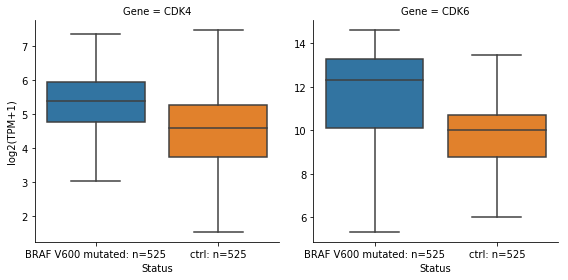

In [68]:
from scipy import stats
import seaborn as sns
yLabel='log2(TPM+1)'
inDf=exprDf.T.stack().reset_index(name=yLabel)
inPlotDf=inDf[inDf[yLabel]>0.5]### an arbitrary threshold to throw away the tail at 0
sns.factorplot(data=inPlotDf,col='Gene',x='Status',y=yLabel,showfliers=False,kind='box',sharey=False)

yay, p-values are less than 0.05 (if you follow the p-values cult)

In [69]:
for inGene in inGenes:
    tmpDf=inPlotDf[inPlotDf['Gene']==inGene]
    tmp_A=tmpDf[tmpDf['Status']==caseLabel][yLabel]
    tmp_B=tmpDf[tmpDf['Status']==ctrlLabel][yLabel]
    t,p=stats.ttest_ind(tmp_A,tmp_B)
    print inGene,p

CDK4 3.65029480737e-08
CDK6 1.60676275114e-35


### What are the labels extracted from annotations of sequencing runs with BRAF V600 mutations


load in biological meta data

In [70]:
metaDataMappingSDir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP//input/allAttrib.v5.csv.NCI.prefilter.pyc'
bio_metaDf=pd.read_pickle(metaDataMappingSDir)

#### slice out the biological meta data associated with BRAF V600 mutations

In [71]:
hitMetaDf=bio_metaDf[bio_metaDf.srs.isin(hitSrrDf['Sample'].unique())]

### the attributes associated with the meta data

picking the restricted attributes you key to slice on usually improve relevancy of labels

In [72]:
hitMetaDf['attrib'].value_counts().head(n=10)

source name             2545
TITLE                   1476
tissue                  1169
bcr abl status          1144
SCIENTIFIC NAME          987
sex                      898
tumor stage              796
biomaterial provider     739
phenotype                665
cell type                655
Name: attrib, dtype: int64

### most commmon terms from annotations of sequencing runs with BRAF V600 mutations

It is unsurprising that "Melnaoma" is in one of the top terms. 

Text(0,0.5,u'# of sequencing runs')

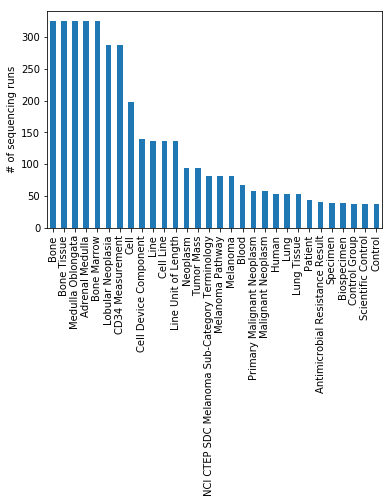

In [73]:
selected_attribs=['source name','TITLE','tissue','phenotype']
ax=hitMetaDf[hitMetaDf['attrib'].isin(selected_attribs)]['NciEng'].value_counts().head(n=30).plot.bar()#.drop_duplicates()
ax.set_ylabel('# of sequencing runs')

### What are the experiments with BRAF V600 mutation that are extracted from Bone?

In [74]:
myHitTechnicalDf=technical_meta_data_df[technical_meta_data_df['Sample'].isin(hitMetaDf[(hitMetaDf['NciEng']=='Bone')]['srs'].values)]

### the top experiment is from this study

In [75]:
myHitTechnicalDf['Study'].value_counts().head(n=2)

SRP067759    287
SRP066263     26
Name: Study, dtype: int64

But it is unexpected that "Bone" show up? 
And when I reference SRA db: 
https://www.ncbi.nlm.nih.gov/sra/?term=SRP067759
It is showing this single cell leukemia RNAseq study study: https://www.nature.com/articles/nm.4336
where luekemia begins in bone marrow.

The BRAF V600 mutation is not mentioned in their study:
But there are multiple evidence to support the confidence of this mutation:

1. Many of their allelic read count usually have the A->T mutation, which is the more common transition for oncogenic transformation.
2. High read depth for alternative allele (T) across across many experiments.
3. High base quality of the alternative allele (T)



In [76]:
queryPosDf=myChrPosDf[(myChrPosDf['Pos']==queryPosition)].set_index(['Run_db','Run_digits'])

In [77]:
queryPosDf['log10_ReadDepth']=np.log10(queryPosDf['ReadDepth'])

In [78]:
subHitDf=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)]

Text(0,0.5,u'# of sequencing runs with more than 5 reads at base')

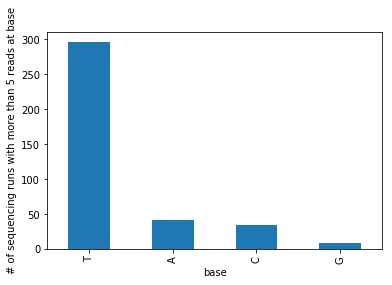

In [79]:
ax=subHitDf.groupby(['base']).size().sort_values(ascending=False).plot.bar()
ax.set_ylabel('# of sequencing runs with more than 5 reads at base')

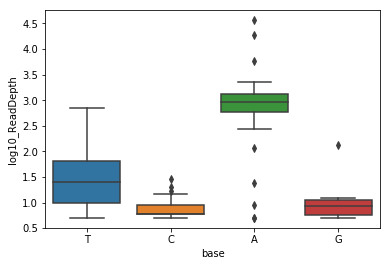

In [80]:
sns.boxplot(data=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)].dropna(),x='base',y='log10_ReadDepth')

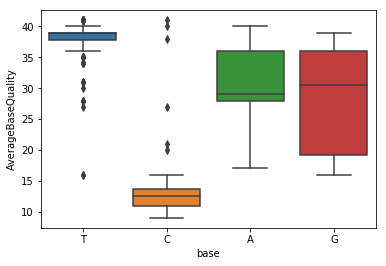

In [81]:
sns.boxplot(data=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)].dropna(),x='base',y='AverageBaseQuality')

In [82]:
!echo /cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/Analysis/AnalyzeExample.ipynb

/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/Analysis/AnalyzeExample.ipynb
